In [138]:
# Import libraries
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math

In [139]:
# Import dataset 
board_games = pd.read_csv("board_games_workfile2.csv", sep=';')
pd.options.display.max_columns = None
board_games.head()

,Unnamed: 0,index,game_id_base,max_players_base,max_playtime_base,min_age_base,min_players_base,min_playtime_base,year_published_base,category_base,average_rating_base,users_rated_base,average_learning_complexity_api,average_strategy_complexity_api,min_age_category_base,year_published_category_base,users_rated_log_base,game_id_base_d,economic_d,negotiation_d,political_d,cardgame_d,fantasy_d,abstractstrategy_d,medieval_d,ancient_d,exploration_d,travel_d,farming_d,mythology_d,bluffing_d,sciencefiction_d,collectiblecomponents_d,dice_d,fighting_d,print&play_d,miniatures_d,racing_d,americanwest_d,citybuilding_d,adventure_d,wargame_d,civilization_d,renaissance_d,humor_d,electronic_d,horror_d,novel-based_d,territorybuilding_d,maze_d,puzzle_d,real-time_d,partygame_d,aviation/flight_d,worldwarii_d,americancivilwar_d,ageofreason_d,worldwari_d,animals_d,childrensgame_d,nautical_d,pirates_d,murder/mystery_d,transportation_d,prehistoric_d,deduction_d,trains_d,industry/manufacturing_d,action/dexterity_d,sports_d,gamesystem_d,wordgame_d,spies/secretagents_d,educational_d,medical_d,mafia_d,zombies_d,comicbook/strip_d,civilwar_d,spaceexploration_d,americanindianwars_d,americanrevolutionarywar_d,napoleonic_d,post-napoleonic_d,book_d,movies/tv/radiotheme_d,arabian_d,memory_d,modernwarfare_d,environmental_d,number_d,religious_d,music_d,trivia_d,pikeandshot_d,videogametheme_d,math_d,vietnamwar_d,mature/adult_d,koreanwar_d,expansionforbase-game_d,price_api,price_ca_api,price_uk_api,price_au_api,discount_api,listing_clicks_api
0,0,0,1,5,240,14,3,240,1986,"Economic,Negotiation,Political",7.66508,4498,0.0,0.0,13-17,1981-1990,8.411388,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0
1,1,1,2,4,30,12,3,30,1981,"Card Game,Fantasy",6.60815,478,0.0,0.0,8-12,1981-1990,6.169611,2.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,69.99,0.00,0.0,0.00,0.0,0
2,2,4,3,4,60,10,2,30,1998,"Abstract Strategy,Medieval",7.44119,12019,0.0,0.0,8-12,1991-2000,9.394244,3.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0
3,3,7,4,4,60,12,2,60,1992,Ancient,6.60675,314,0.0,0.0,8-12,1991-2000,5.749393,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0
4,4,8,5,6,90,12,3,90,1964,Economic,7.35830,15195,0.0,0.0,8-12,1961-1970,9.628722,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,79.99,40.49,0.0,49.99,-1.0,8


In [140]:
# Keep where price is not zero
board_games = board_games[board_games['price_api'] > 0]
board_games = board_games[board_games['price_api'] < 1000]
len(board_games)

2827

In [141]:
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from collections import Counter

In [142]:
df=board_games[[
    'max_players_base',
    #'max_playtime_base',
    'min_age_base',
    'min_players_base',
    'min_playtime_base',
    #'users_rated_base',
    'average_learning_complexity_api'
    #'average_strategy_complexity_api'
]]

data = scale(df)

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  if sys.path[0] == '':


In [143]:
def fit_kmeans(data, num_clusters, init_method):
    if init_method == 'pca':
        pca = PCA(n_components=num_clusters).fit(data)
        estimator = KMeans(init=pca.components_, n_clusters=num_clusters)
    else:
        estimator = KMeans(init=init_method, n_clusters=num_clusters)
    
    estimator.fit(data)
    return estimator

def print_metrics(data, estimator):
    print('Cluster sizes: ', Counter(estimator.labels_).values())
    
dists_dict = {}

for init_method in ['k-means++','random','pca']:
    print(init_method)
    dists_dict[init_method] = []
    for i in range(2,6):      
        estimator = fit_kmeans(data, i, init_method)
        print_metrics(df,estimator)
        dists_dict[init_method].append(estimator.inertia_)

k-means++
Cluster sizes:  dict_values([2536, 291])
Cluster sizes:  dict_values([1286, 1258, 283])
Cluster sizes:  dict_values([1246, 1240, 280, 61])
Cluster sizes:  dict_values([1068, 1293, 278, 129, 59])
random
Cluster sizes:  dict_values([2536, 291])
Cluster sizes:  dict_values([1286, 1258, 283])
Cluster sizes:  dict_values([1246, 1240, 280, 61])
Cluster sizes:  dict_values([1061, 1289, 278, 129, 70])
pca
Cluster sizes:  dict_values([1462, 1365])
Cluster sizes:  dict_values([1283, 1261, 283])
Cluster sizes:  dict_values([438, 1082, 1029, 278])
Cluster sizes:  dict_values([436, 1110, 873, 277, 131])


C:\Users\User\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:971: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:971: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:971: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:971: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


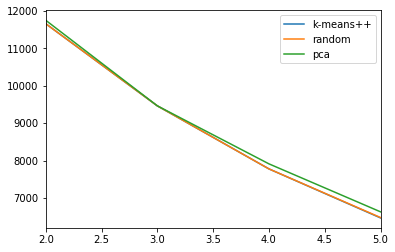

In [50]:
pd.DataFrame(dists_dict).set_index(pd.Index(range(2,6))).plot()

k-means++


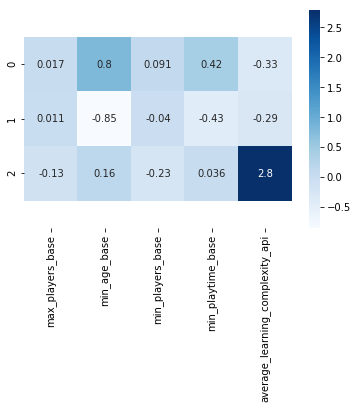

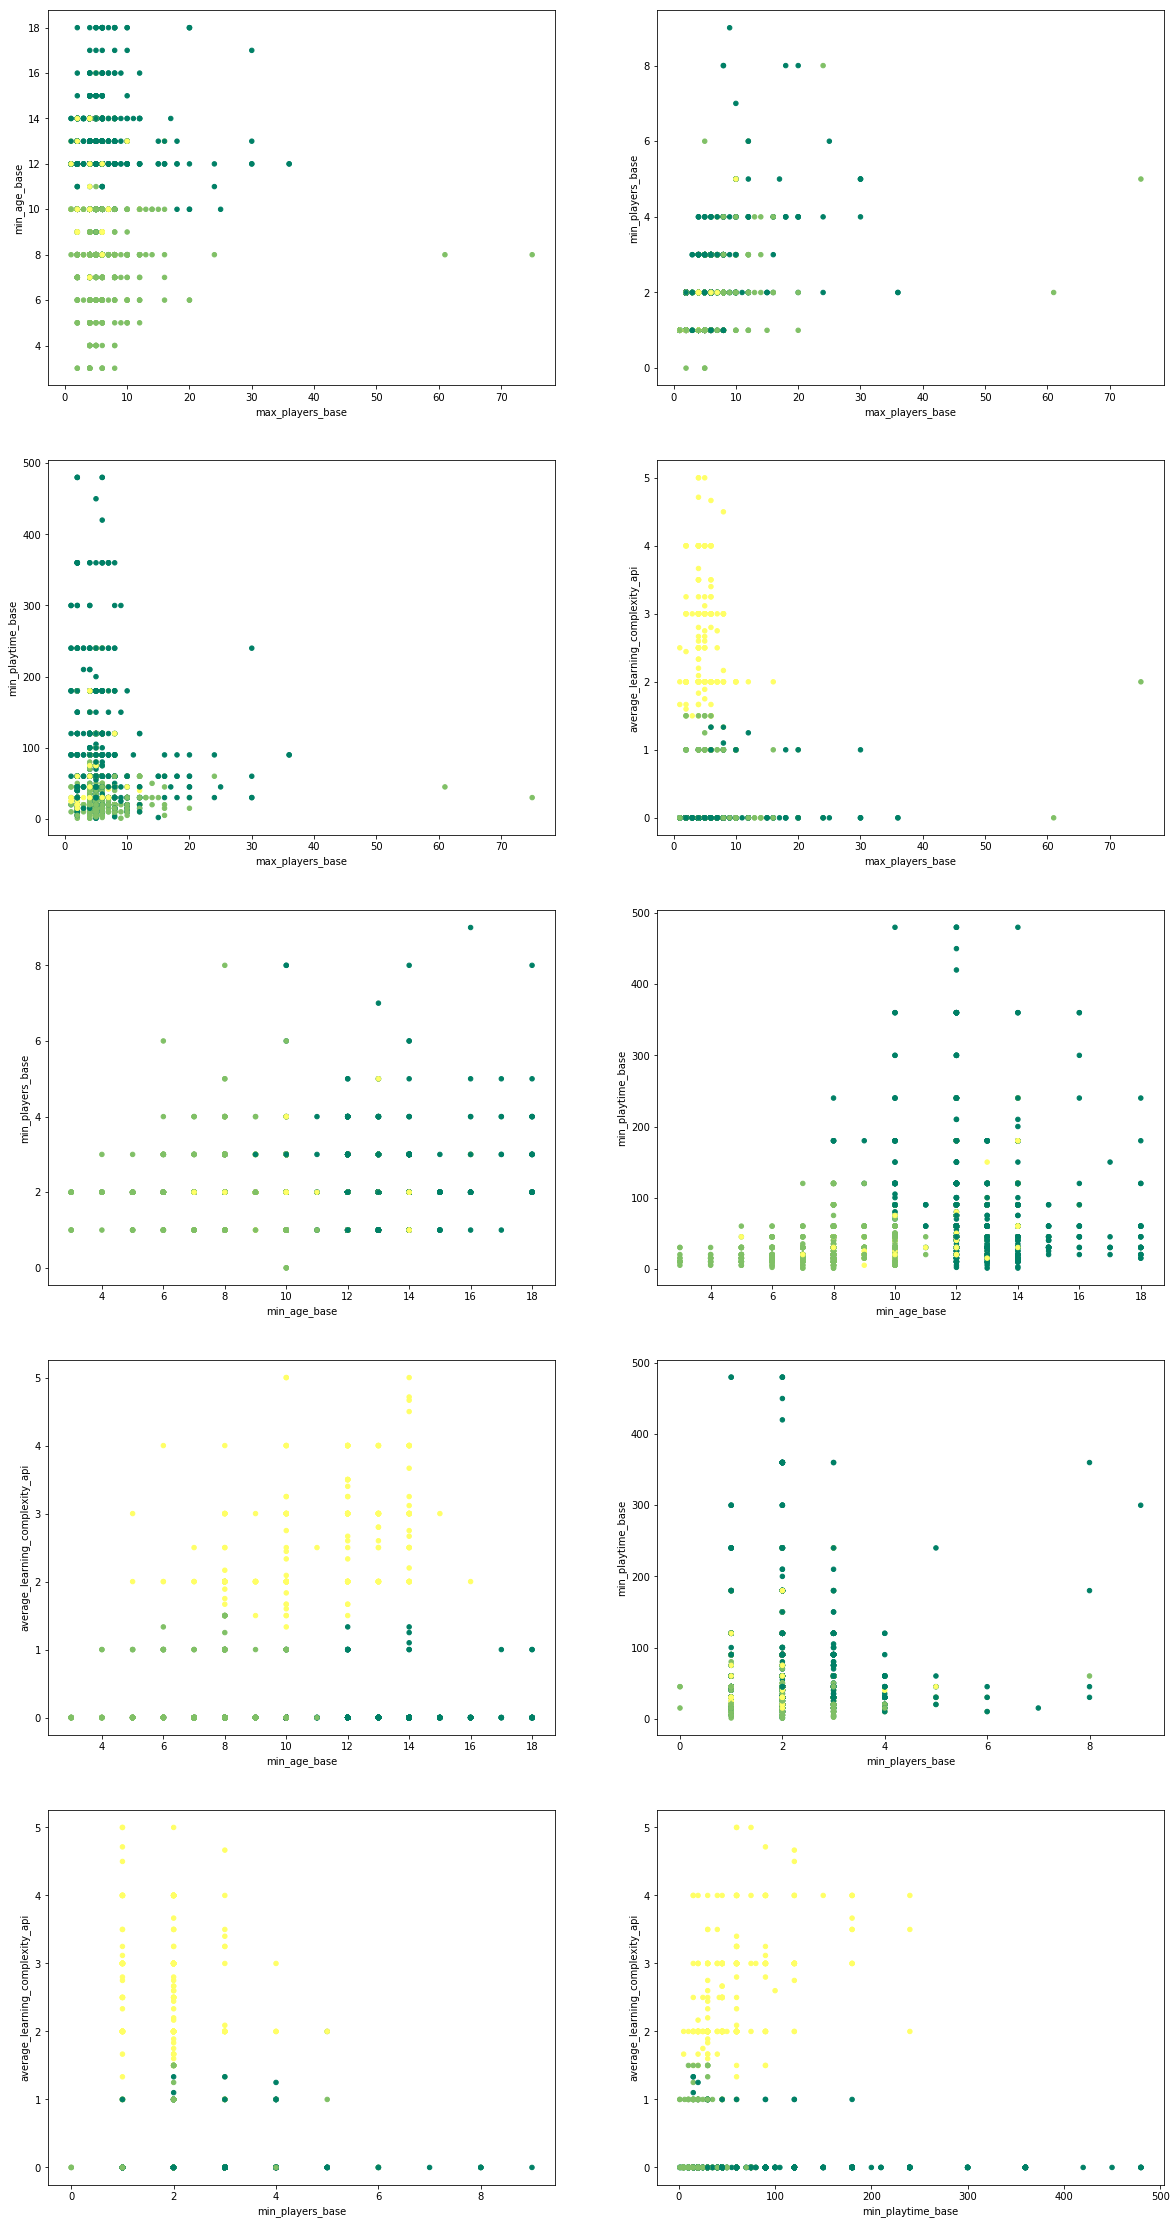

random


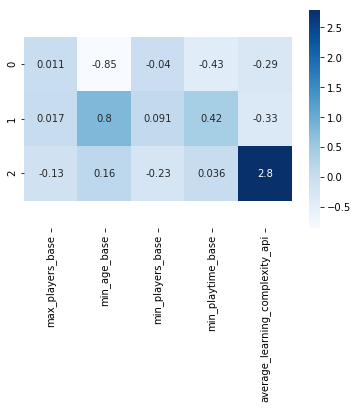

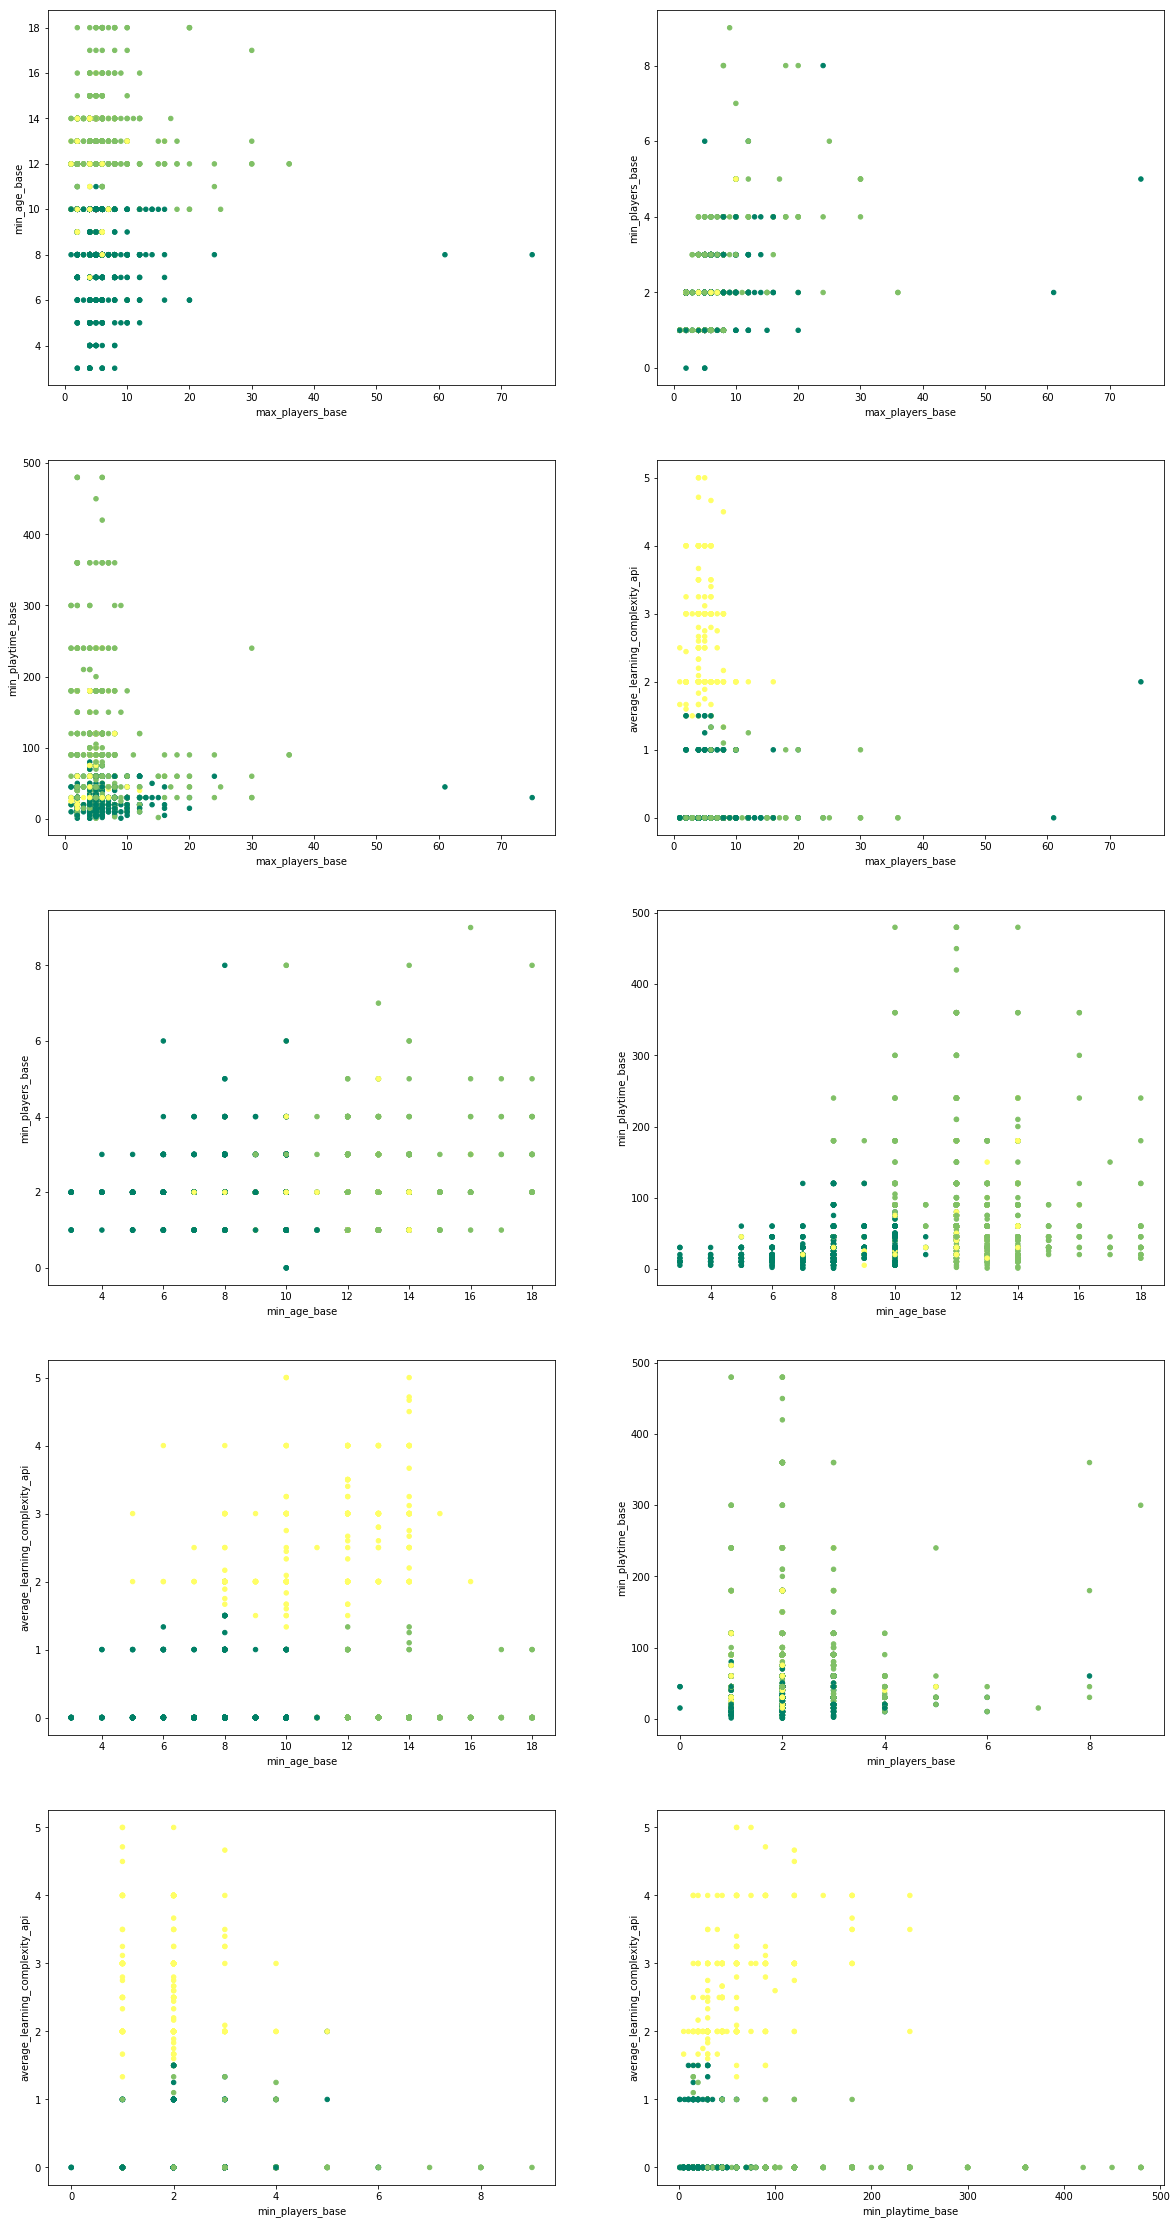

pca


C:\Users\User\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:971: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


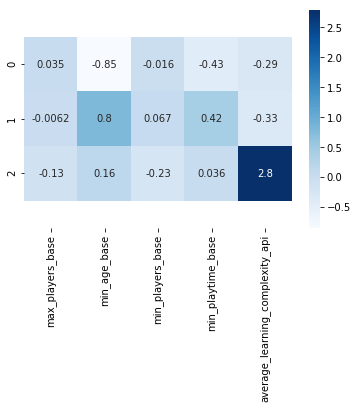

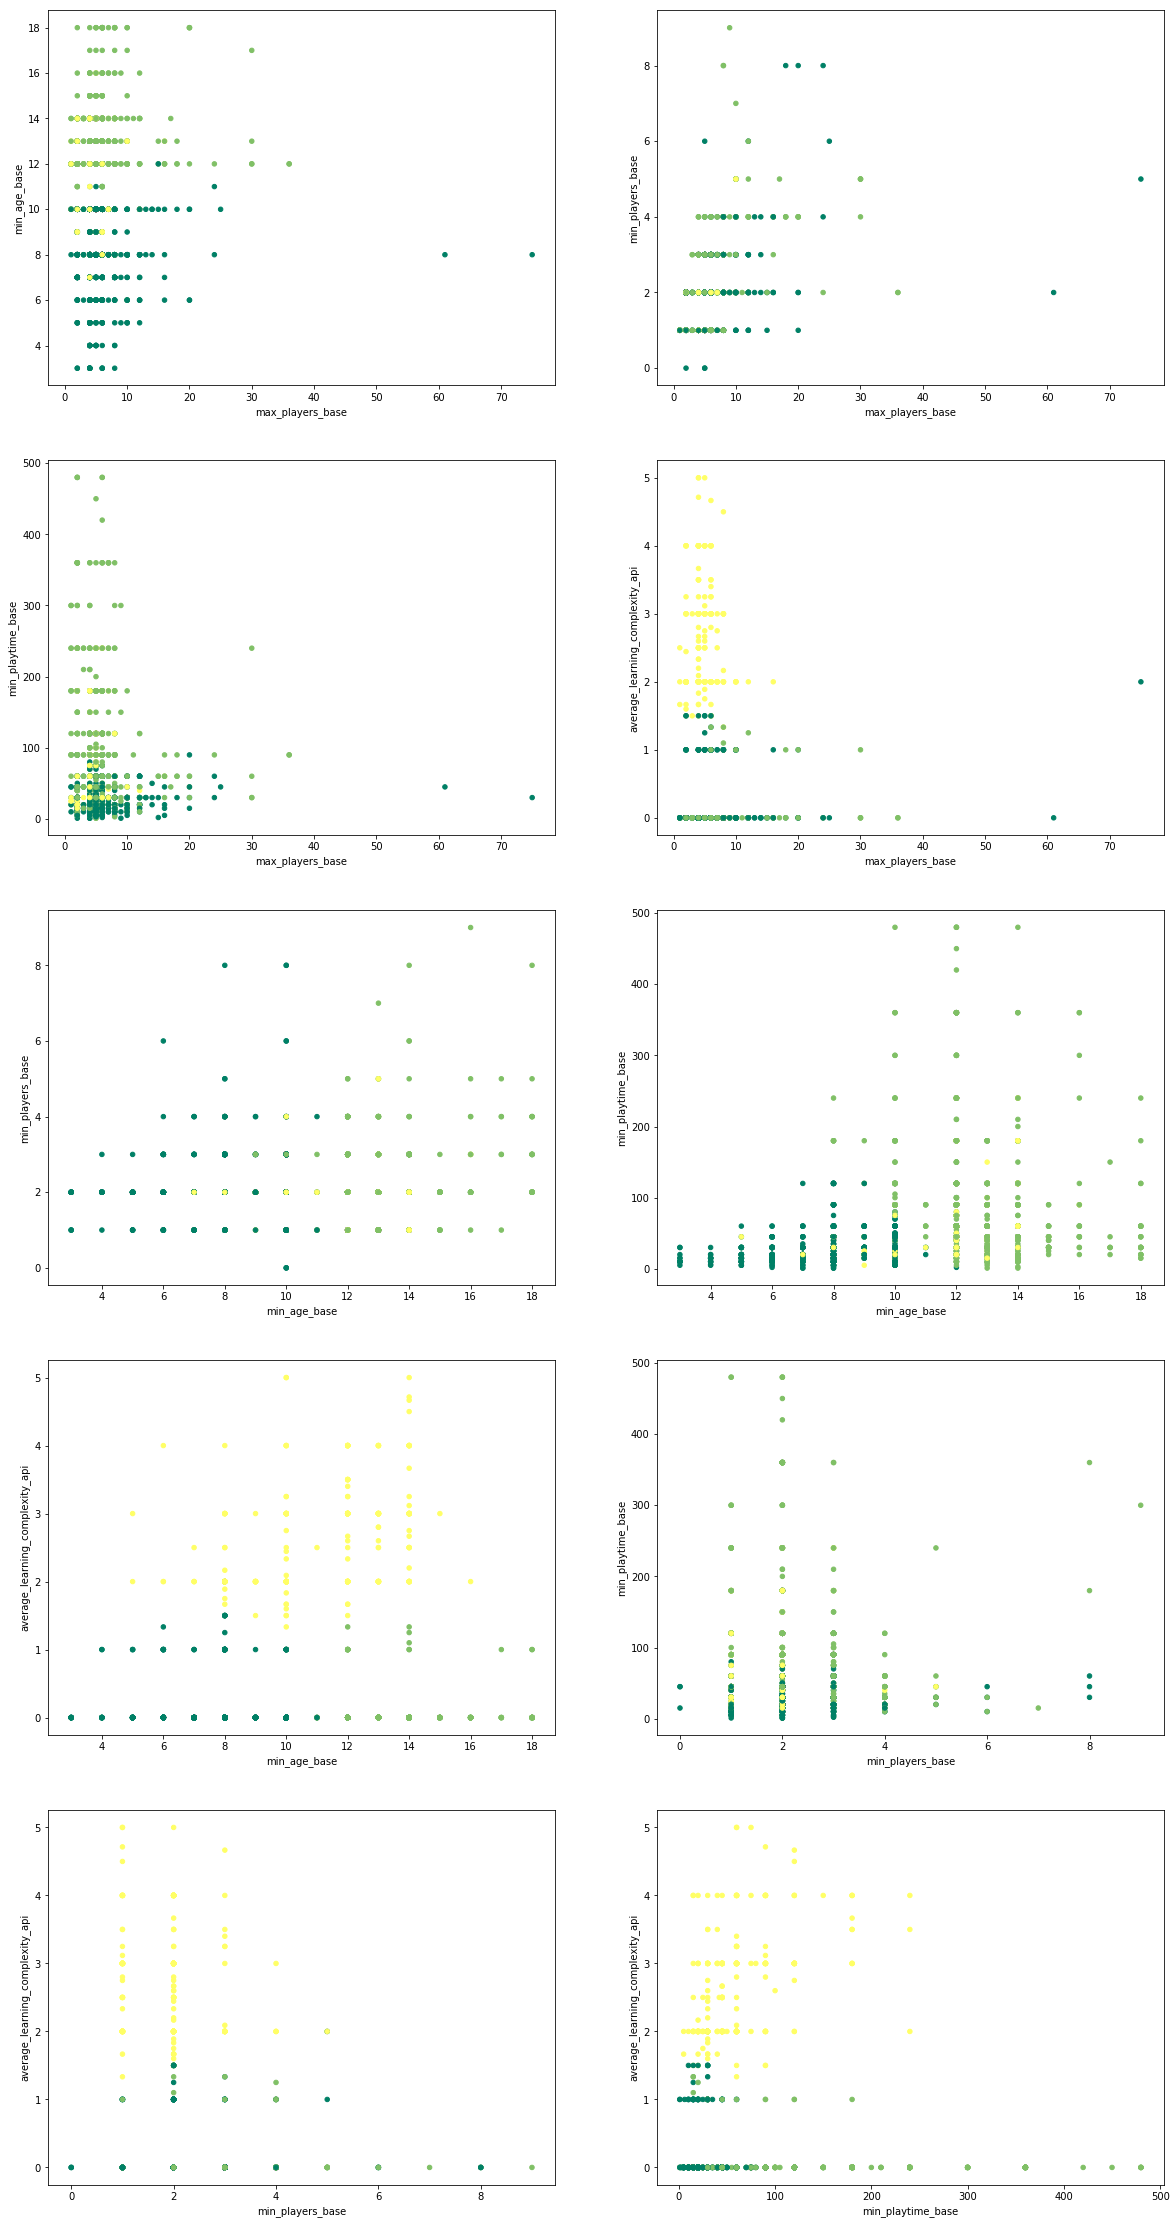

In [162]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from itertools import combinations
%matplotlib inline

def draw_cluster_plot(df, estimator, figsize=(20,40), cmap_name='summer'):
    cmap = matplotlib.cm.get_cmap(cmap_name)
    xy_toplot = list(combinations(df.columns,2))
    fig, axes = plt.subplots(nrows=len(xy_toplot)//2,ncols=2, figsize=figsize)
    i = 0
    for x_ax, y_ax in xy_toplot:
        df.plot.scatter(x=x_ax, y=y_ax, c=estimator.labels_, cmap=cmap, ax=axes[i//2, i%2],colorbar=False)
        i += 1
    plt.show()

for init_method in ['k-means++','random','pca']:
    print(init_method)
    estimator = fit_kmeans(data, 3, init_method)
    centers = pd.DataFrame(estimator.cluster_centers_)
    centers.columns = df.columns
    ax = sns.heatmap(centers, annot=True, cmap='Blues')
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    plt.show()
    draw_cluster_plot(df, estimator)

In [ ]:
# TODO: decide about the init method and choose cluster number, interpret the clusters

In [145]:
# Eg. let's say we chose k-means with 4 clusters

# Fit method
kmeans = fit_kmeans(df, 3, 'k-means++')

# Save cluster membership

board_games['cluster_membership'] = kmeans.labels_
len(kmeans.labels_) # cluster membership

2827

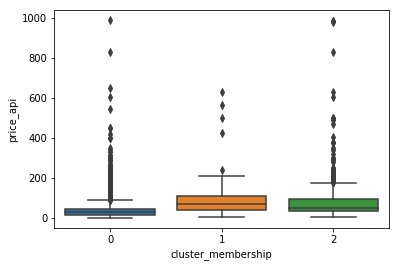

In [146]:
# Distribution of price by clusters
sns.boxplot(data=board_games, x='cluster_membership', y='price_api')

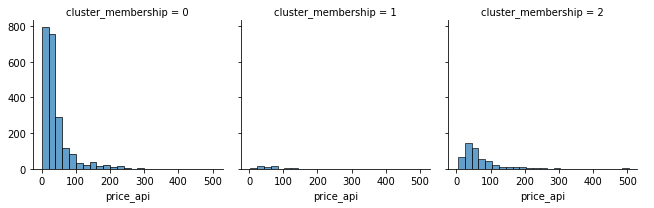

In [147]:
g = sns.FacetGrid(board_games[board_games["price_api"]<500], col="cluster_membership")
g.map(sns.histplot, "price_api", alpha=.7, stat='count', binwidth = 20)
g.add_legend()

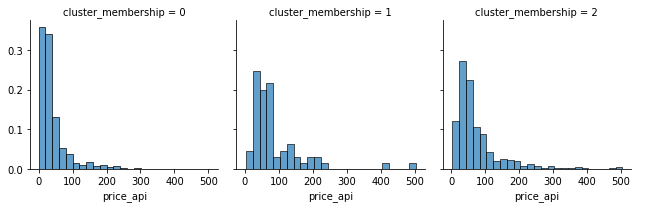

In [164]:
g = sns.FacetGrid(board_games[board_games["price_api"]<500], col="cluster_membership")
g.map(sns.histplot, "price_api", alpha=.7, stat='probability', binwidth = 20)
g.add_legend()

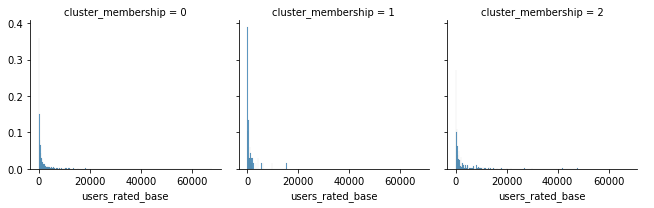

In [169]:
g = sns.FacetGrid(board_games, col="cluster_membership")
g.map(sns.histplot, "users_rated_base", alpha=.7, stat='probability', binwidth = 200)
g.add_legend()

In [151]:
# Most frequent categories in each group
dummies = board_games[board_games.columns[pd.Series(board_games.columns).str.endswith('_d')]]
dummies = dummies.loc[:, ~dummies.columns.isin(['game_id_base_d'])]


dummies["cluster_membership"] = board_games["cluster_membership"]
dummies_grouped = dummies.groupby(['cluster_membership']).sum()
dummies_grouped

,economic_d,negotiation_d,political_d,cardgame_d,fantasy_d,abstractstrategy_d,medieval_d,ancient_d,exploration_d,travel_d,farming_d,mythology_d,bluffing_d,sciencefiction_d,collectiblecomponents_d,dice_d,fighting_d,print&play_d,miniatures_d,racing_d,americanwest_d,citybuilding_d,adventure_d,wargame_d,civilization_d,renaissance_d,humor_d,electronic_d,horror_d,novel-based_d,territorybuilding_d,maze_d,puzzle_d,real-time_d,partygame_d,aviation/flight_d,worldwarii_d,americancivilwar_d,ageofreason_d,worldwari_d,animals_d,childrensgame_d,nautical_d,pirates_d,murder/mystery_d,transportation_d,prehistoric_d,deduction_d,trains_d,industry/manufacturing_d,action/dexterity_d,sports_d,gamesystem_d,wordgame_d,spies/secretagents_d,educational_d,medical_d,mafia_d,zombies_d,comicbook/strip_d,civilwar_d,spaceexploration_d,americanindianwars_d,americanrevolutionarywar_d,napoleonic_d,post-napoleonic_d,book_d,movies/tv/radiotheme_d,arabian_d,memory_d,modernwarfare_d,environmental_d,number_d,religious_d,music_d,trivia_d,pikeandshot_d,videogametheme_d,math_d,vietnamwar_d,mature/adult_d,koreanwar_d,expansionforbase-game_d
cluster_membership,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,144.0,70.0,43.0,819.0,350.0,186.0,137.0,83.0,82.0,25.0,30.0,60.0,191.0,196.0,36.0,240.0,207.0,37.0,80.0,62.0,29.0,84.0,115.0,104.0,49.0,37.0,163.0,29.0,84.0,66.0,77.0,24.0,62.0,115.0,259.0,19.0,37.0,6.0,4.0,5.0,150.0,153.0,60.0,45.0,47.0,36.0,24.0,175.0,35.0,38.0,93.0,37.0,2.0,62.0,42.0,48.0,10.0,13.0,47.0,40.0,1.0,37.0,1.0,2.0,3.0,4.0,3.0,115.0,13.0,52.0,10.0,22.0,21.0,14.0,7.0,59.0,0.0,37.0,6.0,0.0,15.0,0.0,3.0
1,13.0,8.0,7.0,2.0,1.0,0.0,2.0,8.0,1.0,0.0,0.0,0.0,2.0,6.0,0.0,1.0,2.0,0.0,1.0,0.0,1.0,2.0,2.0,52.0,5.0,2.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0,15.0,1.0,6.0,4.0,0.0,0.0,3.0,0.0,2.0,4.0,0.0,0.0,7.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,2.0,0.0,1.0,2.0,1.0,0.0,1.0,0.0,0.0,5.0,0.0,0.0,1.0,0.0,1.0,2.0,0.0,0.0,2.0,1.0,2.0,0.0
2,146.0,56.0,40.0,51.0,90.0,5.0,45.0,34.0,51.0,5.0,9.0,9.0,23.0,78.0,3.0,25.0,89.0,4.0,40.0,7.0,11.0,43.0,67.0,85.0,44.0,31.0,25.0,3.0,26.0,28.0,45.0,0.0,2.0,3.0,15.0,8.0,22.0,4.0,7.0,2.0,6.0,6.0,24.0,7.0,10.0,33.0,8.0,9.0,22.0,27.0,2.0,7.0,0.0,1.0,5.0,7.0,1.0,4.0,12.0,7.0,6.0,21.0,3.0,1.0,5.0,3.0,2.0,30.0,6.0,1.0,9.0,5.0,3.0,5.0,2.0,12.0,0.0,17.0,3.0,2.0,1.0,1.0,0.0


In [163]:
# Transpose
dummies_grouped_t = dummies_grouped.T 

In [153]:
type(dummies_grouped_t)
# dummies_grouped_t.columns

pandas.core.frame.DataFrame

In [155]:
dummies_grouped_t[0].sort_values(ascending=False).head(20)

cardgame_d                819.0
fantasy_d                 350.0
partygame_d               259.0
dice_d                    240.0
fighting_d                207.0
sciencefiction_d          196.0
bluffing_d                191.0
abstractstrategy_d        186.0
deduction_d               175.0
humor_d                   163.0
childrensgame_d           153.0
animals_d                 150.0
economic_d                144.0
medieval_d                137.0
real-time_d               115.0
movies/tv/radiotheme_d    115.0
adventure_d               115.0
wargame_d                 104.0
action/dexterity_d         93.0
horror_d                   84.0
Name: 0, dtype: float64

In [156]:
dummies_grouped_t[1].sort_values(ascending=False).head(20)

wargame_d            52.0
worldwarii_d         15.0
economic_d           13.0
ancient_d             8.0
negotiation_d         8.0
trains_d              7.0
political_d           7.0
sciencefiction_d      6.0
ageofreason_d         6.0
modernwarfare_d       5.0
civilization_d        5.0
worldwari_d           4.0
transportation_d      4.0
nautical_d            3.0
aviation/flight_d     2.0
adventure_d           2.0
citybuilding_d        2.0
koreanwar_d           2.0
murder/mystery_d      2.0
renaissance_d         2.0
Name: 1, dtype: float64

In [157]:
dummies_grouped_t[2].sort_values(ascending=False).head(20)

economic_d                146.0
fantasy_d                  90.0
fighting_d                 89.0
wargame_d                  85.0
sciencefiction_d           78.0
adventure_d                67.0
negotiation_d              56.0
exploration_d              51.0
cardgame_d                 51.0
territorybuilding_d        45.0
medieval_d                 45.0
civilization_d             44.0
citybuilding_d             43.0
miniatures_d               40.0
political_d                40.0
ancient_d                  34.0
transportation_d           33.0
renaissance_d              31.0
movies/tv/radiotheme_d     30.0
novel-based_d              28.0
Name: 2, dtype: float64

In [16]:
# Price variables
price = board_games.loc[:, board_games.columns.isin([
    'price_api',
    'price_au_api',
    'price_ca_api',
    'price_uk_api'
    ])]
price.head()

,price_api,price_au_api,price_ca_api,price_uk_api
0,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00
2,13.79,13.99,18.89,0.00
3,39.19,51.00,36.97,35.78
4,0.00,49.95,199.99,0.00


In [17]:
# Check nulls
price.isnull().sum()

price_api       0
price_au_api    0
price_ca_api    0
price_uk_api    0
dtype: int64

In [10]:
price.agg(
    {
        "price_api": ["min", "max", "mean", "median", "std"],
        "price_au_api": ["min", "max", "mean", "median", "std"],
        "price_ca_api": ["min", "max", "mean", "median", "std"],        
        "price_uk_api": ["min", "max", "mean", "median", "std"]          
    }
)

,price_api,price_au_api,price_ca_api,price_uk_api
min,0.000000,0.000000,0.000000,0.000000
max,1138.310000,324.950000,848.910000,159.990000
mean,33.457744,24.072788,25.626535,7.045439
median,19.950000,0.000000,15.990000,0.000000
std,58.851721,36.960862,43.845709,15.283440


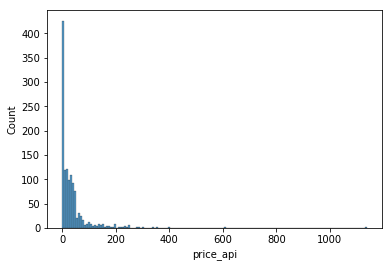

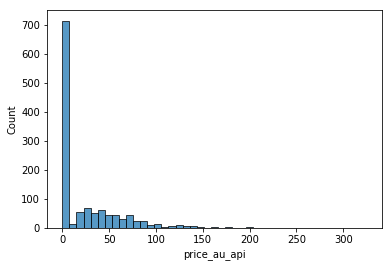

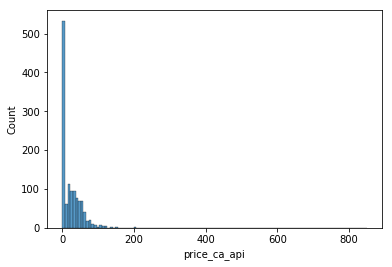

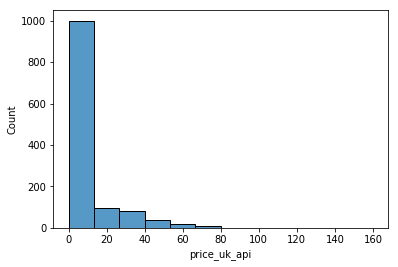

In [15]:
# Check histograms
price_list = price.columns.values.tolist()
price_list

for x in price_list: 
    sns.histplot(price[x])
    plt.show()

In [20]:
# Zeros
print(len(price[price['price_api']==0])/len(price),
len(price[price['price_au_api']==0])/len(price),
len(price[price['price_ca_api']==0])/len(price),
len(price[price['price_uk_api']==0])/len(price))

0.3295729250604351 0.5753424657534246 0.4262691377921031 0.7598710717163578


In [27]:
# p
price['price_api_cat'] = pd.cut(x=price['price_api'], 
                     bins=[0, 1, 100000000000000000000],
                     labels=['0', 
                             '1'])

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [30]:
agg = price.groupby('price_api_cat').agg({'price_api':'min'}).rename(columns={'price_api':'mean'})
agg

,mean
price_api_cat,
0,NaN
1,1.75


In [33]:
price['price_api_cat'] = np.where(price['price_api'] == 0, 0, 1)

price

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,price_api,price_au_api,price_ca_api,price_uk_api,price_api_cat
0,0.00,0.00,0.00,0.00,0
1,0.00,0.00,0.00,0.00,0
2,13.79,13.99,18.89,0.00,1
3,39.19,51.00,36.97,35.78,1
4,0.00,49.95,199.99,0.00,0
5,0.00,0.00,0.00,0.00,0
6,0.00,0.00,0.00,0.00,0
7,60.42,72.95,0.00,0.00,1
8,249.99,0.00,0.00,0.00,1
9,0.00,0.00,0.00,0.00,0
